<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Разреженные данные, онлайн-обучение</center>
## <center>Часть 2. Классификация отзывов к фильмам с SVM и логистической регрессией</center>

In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [2]:
# поменяйте путь к файлу
#reviews_train = load_files("/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews/train/")
reviews_train = load_files("d:tmp/imdb_reviews/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

In [3]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [4]:
# поменяйте путь к файлу
#reviews_test = load_files("/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews/test/")
reviews_test = load_files("d:tmp/imdb_reviews/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [5]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [6]:
y_train[1] # плохой отзыв

0

In [7]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [8]:
y_train[2] # хороший отзыв

1

**Идея "мешка слов"**

<img src="../../img/bag_of_words.svg" width=80%>

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [9]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [10]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [11]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [12]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [13]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562])

In [14]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150, 66562]))

**Преобразуем так же тестовую выборку.**

In [15]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию и линейный SVM.**

In [16]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Wall time: 13.5 s


In [17]:
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_train, y_train)

Wall time: 6.95 s


**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [18]:
round(logit.score(X_train, y_train), 3), round(svm.score(X_train, y_train), 3)

(0.998, 1.0)

In [19]:
round(logit.score(X_test, y_test), 3), round(svm.score(X_test, y_test), 3)

(0.86699999999999999, 0.84599999999999997)

In [20]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [46]:
def plot_grid_scores(grid, param_name):
    plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    legend();
    

In [43]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import legend

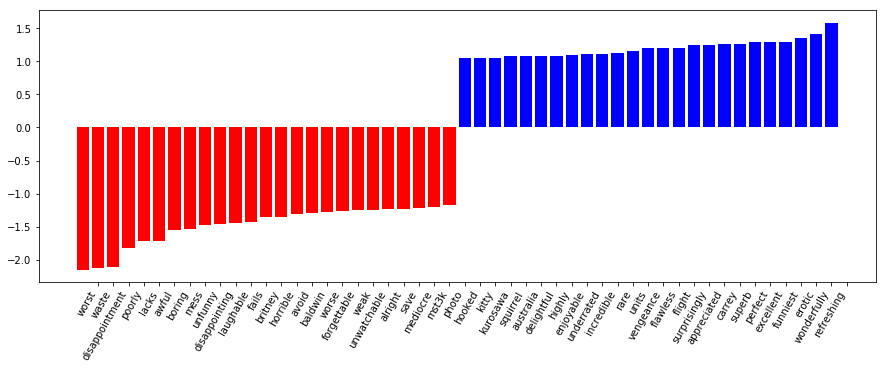

In [24]:
visualize_coefficients(logit, cv.get_feature_names())

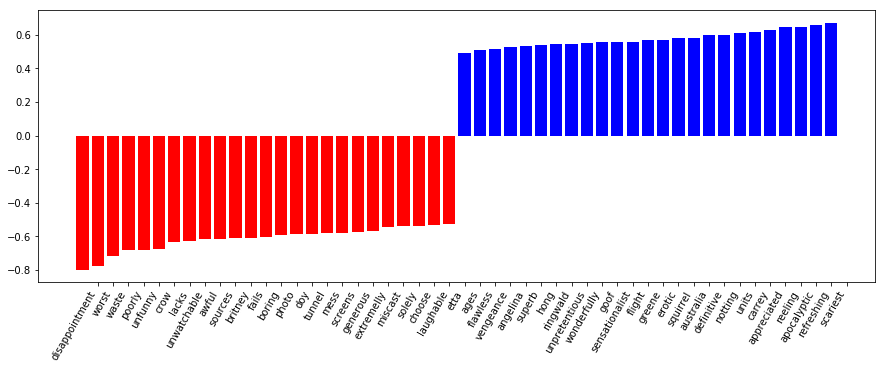

In [25]:
visualize_coefficients(svm, cv.get_feature_names())

**Подберем коэффициент регуляризации для логистической регрессии.**

In [26]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.86676
Wall time: 21.8 s


In [27]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': 
                    np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Wall time: 1min 55s


**Лучшее значение C и соответствующее качество на кросс-валидации.**

In [28]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.10000000000000001}, 0.88524000000000003)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


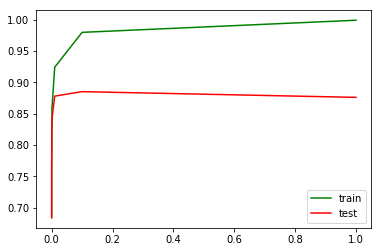

In [48]:
plot_grid_scores(grid_logit, 'logisticregression__C');

**То же самое для LinearSVC.**

In [30]:
%%time
text_pipe_svm = make_pipeline(CountVectorizer(), LinearSVC(random_state=7))

text_pipe_svm.fit(text_train, y_train)
print(text_pipe_svm.score(text_test, y_test))

0.84584
Wall time: 15.9 s


In [31]:
%%time
param_grid_svm = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_svm, param_grid_svm, cv=3, n_jobs=-1)

grid_svm.fit(text_train, y_train);

Wall time: 1min 47s


In [32]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.88307999999999998)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


NameError: name 'legend' is not defined

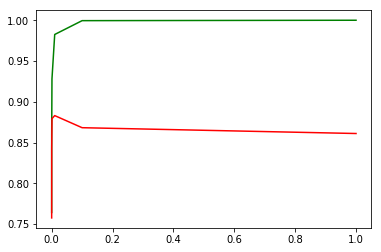

In [36]:
plot_grid_scores(grid_svm, 'linearsvc__C')

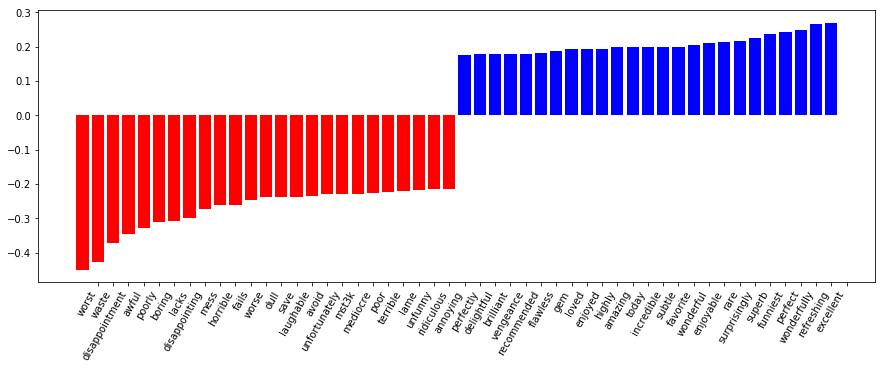

In [37]:
visualize_coefficients(grid_svm.best_estimator_.named_steps['linearsvc'],
                       grid_svm.best_estimator_.named_steps['countvectorizer'].get_feature_names())

На валидационной выборке:

In [38]:
grid_logit.score(text_test, y_test), grid_svm.score(text_test, y_test)

(0.87904000000000004, 0.87587999999999999)

## TF-IDF

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


NameError: name 'legend' is not defined

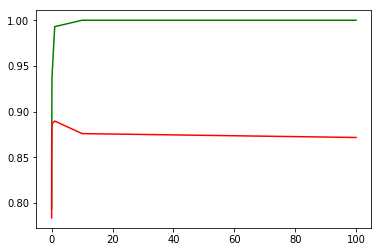

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pipe = make_pipeline(TfidfVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid_tfidf = GridSearchCV(tfidf_pipe, param_grid, cv=3, n_jobs=-1)
grid_tfidf.fit(text_train, y_train)
plot_grid_scores(grid_tfidf, 'linearsvc__C')

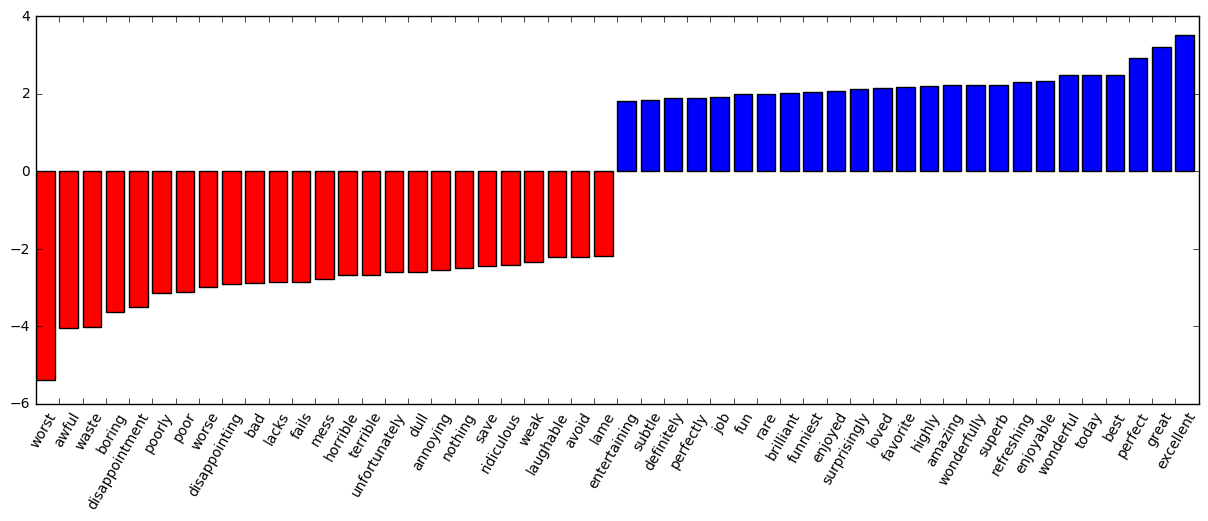

In [26]:
visualize_coefficients(grid_tfidf.best_estimator_.named_steps['linearsvc'],
                       grid_tfidf.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names())

In [27]:
grid_tfidf.best_score_, grid_tfidf.best_params_

(0.88976, {'linearsvc__C': 1.0})

## N-граммы

In [50]:
%%time
text_pipe = make_pipeline(CountVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': [0.01, 0.1, 1],
              "countvectorizer__ngram_range": [(1, 2)]}

grid_bigram = GridSearchCV(text_pipe, param_grid, cv=3)

grid_bigram.fit(text_train, y_train)

Wall time: 8min 8s


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


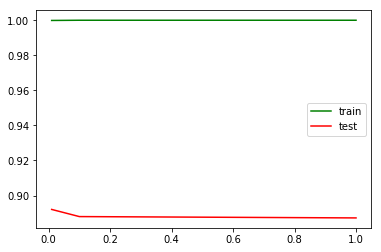

In [51]:
plot_grid_scores(grid_bigram, 'linearsvc__C')

In [52]:
grid_bigram.best_score_

0.89207999999999998